# Van der Pol Oscillator

Now it is your turn. Use what you learned in the previous notebook exercise to solve the Van der Pol Oscillator in a bundle using PINNs.

The equation for the van der pol oscillator is:
$$\frac{d^2 x}{dt^2} - a (1-x^2)\frac{dx}{dt} + x = 0$$

with initial Robin (mixed) conditions:
$$x(0) = 1 \,\,\,;\,\,\,x'(0)=0$$

Reminder: remember PINNs usually converge better when solving (systems of) 1st order ODEs.

### (Solution): 
We can transform the above equation to a system of 1st order ODEs like:
$$\left\{\begin{aligned}
& x'(t) - y(t) = 0 \\
& y'(t) - a(1-x^2) + x = 0
\end{aligned}\right.$$
with ICs: 
$$\left\{\begin{aligned}
& x(0) = 1 \\
& y(0) = 0
\end{aligned}\right.$$

Do this for a bundle in the parameter $a$, for a range $a\in[a_\text{min},a_\text{min}]$ that spans the biggest range you can, mantaining proper convergence.


### Import the needed packages

If you find a message like:

You can install the package using:
!pip install package_name

or you can install the $\texttt{requirements.txt}$ available in the Github

In [1]:
import numpy as np
import torch
from tqdm.notebook import tqdm
from neurodiffeq.conditions import BundleIVP, IVP
from neurodiffeq import diff
from neurodiffeq.networks import FCNN
from neurodiffeq.generators import BaseGenerator,Generator1D, PredefinedGenerator, MeshGenerator
from torch import nn
from neurodiffeq.solvers import BundleSolver1D
from neurodiffeq.callbacks import ActionCallback 
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
import math
import os


In [2]:
# !pip install numpy
# !pip install torch
# !pip install neurodiffeq
# !pip install -U jupyter ipywidgets
# !pip install ipywidgets

# !pip install matplotlib

### Create the equation

Let us first define the equation.

Note that for $\texttt{neurodiffeq}$, the variables input to the equations have to appear in the following order:
1. Dependent variables (x,y)
2. Independent variable (t)
3. (Optional) Other inputs to the equation, in this case our parameter k

In [3]:
def VdP_equation(x, y, t, a): #, k=1.0):

    eq1 = diff(x,t, order = 1) - y  # definition of velocity
    eq2 = diff(y, t, order = 1) - a * (1-x**2) * y + x  # VdP Oscillator equation

    return [eq1, eq2]


### Define the BC/ICs

The boundary conditions within neurodiffeq are defined as follows:

- Use IVP or DirichletBVP, etc. for non-bundle IC/BC
- Use BundleIVP, BundleDirichletBVP, etc. for bundle BC

Read the docs for more information.

In [ ]:
conditions = [
    IVP(0, 1),  # condition on x(t=0)
    IVP(0, 0),  # condition on y(t=0)
]


### Create the NNs

The NNs used can be Fully Connected Neural Networks (FCNN), or they can have more exotic architectures, for which they have to be defined specifically.

For our FCNN case within $\texttt{PyTorch}$ and neurodiffeq, we can choose number of inputs, outputs, hidden layers (and neurons within each hidden layer), and activation function (see pytorch documentation for other activation functions).

In our case, since we want to predict two different variables $x(t)$ and $y(t)$, we define 2 NNs, one per variable.

Each NN takes 1 input - the independent variable $t$ - if we have fixed $k$ and ICs $x_0/y_0$, 2 inputs if we want to do a bundle over one of the two ($k$ or $x_0$), or 3 inputs if we want to do a bundle over both.



In [5]:
hidden_layers = [16,16,16]

actv = nn.Tanh

nets = [FCNN(n_input_units=2, hidden_units=hidden_layers, n_output_units=1, actv=actv) for _ in range(2)]



### Define Optimizer and Scheduler

The optimizer can be chosen from the ones available in $\texttt{PyTorch}$, for example:
- 1st order optimizers like SGD (Stochastic Gradient Descent) or $\texttt{Adam}$ (SGD with momenta - betas, see: )
- 2nd order optimizers like LBFGS (much more computationally intensive)


In [6]:
optimizer = torch.optim.Adam(params=[p for net in nets for p in net.parameters()], 
                                lr=1e-3,
                                # betas=(0.9, 0.99))
                                )



### Define specifications of the problem

Time we will be solving for, range for the IC/BCs bundle, range for the parameter's bundle

In [ ]:
t_min = 0.0
t_max = 5.0

a_min = 1.0
a_max = 5.0

# x0_min = -1.0
# x0_max = 1.0



### Sample and visualize the Generators (indep. var., bundle params.) 

In [ ]:
n_points = 64
n_a_points = 32
# n_x0_points = 32

g1 = Generator1D(n_points, t_min, t_max, method='equally-spaced')

a_gen = Generator1D(n_a_points, a_min, a_max, method='equally-spaced')
# x0_gen = Generator1D(n_x0_points, x0_min, x0_max, method='equally-spaced')

train_generator = MeshGenerator(g1, a_gen)



### Define the Solver
It takes everything created up to this point and will be in charge of the training process. For the internal structure, see $\texttt{neurodiffeq}$ bibliography.

In [35]:
class DoSchedulerStep(ActionCallback):
    def __init__(self, scheduler):
        super().__init__()
        self.scheduler = scheduler

    def __call__(self, solver):
        self.scheduler.step()

In [36]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.985)
scheduler_cb = DoSchedulerStep(scheduler=scheduler)

In [37]:
solver = BundleSolver1D(
    ode_system=VdP_equation,
    conditions=conditions,
    nets=nets,
    optimizer=optimizer,
    train_generator = train_generator,
    t_min=t_min, 
    t_max=t_max, 
    eq_param_index=(0,),  # k is the only equation parameter, which has index 0
    n_batches_valid=0,
)

### (Optional) Load pretrained model
This function allows to load a pretrained model into the solver model that was just generated, as long as it has been saved previously using a function as defined in the posterior subsection "Save results"

In [13]:
def load_model(model, path):

    master_dict = torch.load(path, map_location='cpu', weights_only=False)

    # model.global_epoch = master_dict['epoch']

    nets_architecture = master_dict['nets_architecture']

    print(nets_architecture[f'net_{0}']['activations'][0])

    model.nets = [FCNN(n_input_units=nets_architecture[f'net_{i}']['n_input'], \
                        hidden_units=nets_architecture[f'net_{i}']['hidden_layers'], \
                        n_output_units=nets_architecture[f'net_{i}']['n_output'], \
                        actv = getattr(nn, nets_architecture[f'net_{i}']['activations'][0])  # dynamic activation
                ) for i in range(len(nets_architecture))]

    for i in range(len(model.nets)):
        model.nets[i].load_state_dict(master_dict['nets_state'][i])

    model.metrics_history['train_loss'] = master_dict['train_loss']
    model.metrics_history['valid_loss'] = master_dict['validation_loss']

    print('Pretrained model sucessfully loaded')

In [14]:
# path_pretrained_model = f'{os.getcwd()}/results/test_1/NN_epochs_5000'

# load_model(model = solver, path = path_pretrained_model)

### Train the net

In [79]:
epochs = 5000

solver.fit(max_epochs=epochs, 
                callbacks=[scheduler_cb], 
                )
        

Training Progress:   0%|          | 0/5000 [00:00<?, ?it/s]

### Visualize the results

Here we can visualize the training loss function (and validation if it exists), solutions obtained by the NN and residuals of the differential equations

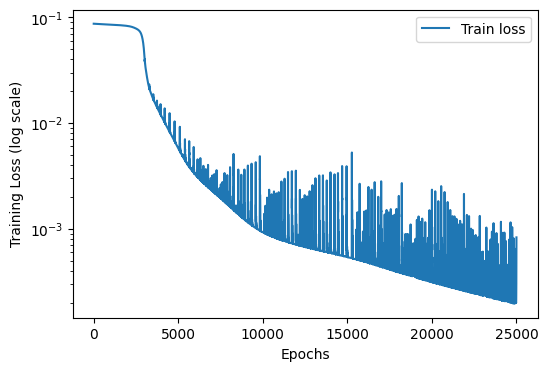

In [80]:
loss = solver.metrics_history['train_loss']

fig = plt.figure(figsize=(6,4))
plt.plot(loss, label = 'Train loss')
plt.xlabel('Epochs')
plt.ylabel('Training Loss (log scale)')
plt.yscale('log')
plt.legend()
plt.show()

### Solutions for different k values

#### Numerical solution

In [87]:

num_solutions = []

a_values = np.linspace(a_min,a_max, 5)

print(a_values)


for k_val in a_values:
    
    def VdP_num_equation(t, state, a=k_val):
        x, y = state
        dxdt = y
        dydt = a * (1-x**2)*y - x
        return [dxdt, dydt]
    
    # Initial conditions
    x0 = 1.0
    y0 = 0.0
    t_span = (t_min, t_max)
    t_eval = np.linspace(*t_span, 1000)

    # Solve
    num_sol = solve_ivp(VdP_num_equation, t_span, [x0, y0], t_eval=t_eval)

    num_solutions.append(num_sol)

print(len(num_solutions))



[1.   1.25 1.5  1.75 2.  ]
5


#### PINN solutions

In [88]:
step=1
best=True

t = torch.linspace(t_min, t_max, 250)

x_solutions = []
y_solutions = []


sol = solver.get_solution(best = best)

for i, k_val in enumerate(a_values):

    k_input = k_val*torch.ones_like(t)

    # for j, x0_val in enumerate(x0_values):
    # x0_input = x0_val * torch.ones_like(t)
    
    x_sol, y_sol = sol(t, k_input) #, x0_input)

    x_solutions.append(x_sol.cpu().detach().numpy())
    y_solutions.append(y_sol.cpu().detach().numpy())


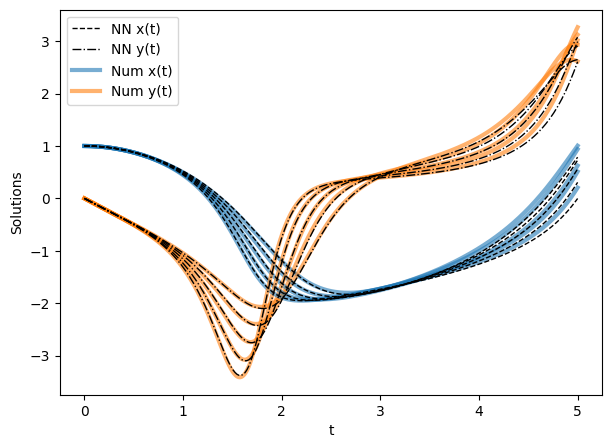

In [89]:
fig = plt.figure(figsize=(7, 5))

for i, k_val in enumerate(a_values):
    if i==0:
        plt.plot(t.cpu().detach().numpy(), x_solutions[i], label=f'NN x(t)', linestyle='dashed', linewidth=1, color ='k')
        plt.plot(t.cpu().detach().numpy(), y_solutions[i], label=f'NN y(t)',  linestyle='dashdot', linewidth=1, color ='k')
        plt.plot(num_solutions[i].t, num_solutions[i].y[0], '-', label=f'Num x(t)',  color ='C0',linewidth=3, alpha=0.6, zorder=0)
        plt.plot(num_solutions[i].t, num_solutions[i].y[1],'-', label=f'Num y(t)',  color ='C1', linewidth=3,alpha=0.6, zorder=0)
    else:
        plt.plot(t.cpu().detach().numpy(), x_solutions[i], linestyle='dashed', linewidth=1, color ='k')
        plt.plot(t.cpu().detach().numpy(), y_solutions[i], linestyle='dashdot', linewidth=1, color ='k')
        plt.plot(num_solutions[i].t, num_solutions[i].y[0], '-',  color ='C0',linewidth=3, alpha=0.6, zorder=0)
        plt.plot(num_solutions[i].t, num_solutions[i].y[1],'-', color ='C1', linewidth=3,alpha=0.6, zorder=0)

plt.legend(loc='best')
plt.xlabel('t')
plt.ylabel('Solutions')

plt.show()

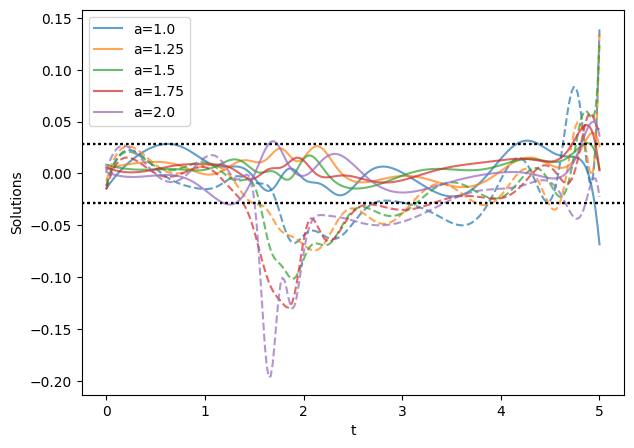

In [90]:
fig = plt.figure(figsize=(7, 5))

for i, k_val in enumerate(a_values):
    
    k_input = k_val*torch.ones_like(t)

    res1, res2 = solver.get_residuals(t, k_input, best = False)

    plt.plot(t.cpu().detach().numpy(), res1.cpu().detach().numpy(), '-', label=f'a={k_val}', color = f'C{i}', alpha = 0.7)
    plt.plot(t.cpu().detach().numpy(), res2.cpu().detach().numpy(),'--', color = f'C{i}', alpha = 0.7)

    plt.axhline(np.sqrt(solver.metrics_history['train_loss'][-1]), color='k', linestyle='dotted')
    plt.axhline(-np.sqrt(solver.metrics_history['train_loss'][-1]), color='k', linestyle='dotted')

plt.legend(loc='best')
plt.xlabel('t')
plt.ylabel('Solutions')

plt.show()

### Save the results (optional)

This function allows us to save the current state of the PINN model. This is extremely useful as a checkpoint furing training, in case any user wants to reload a prertained model to visualize results, analize them, keep on training, etc.

In [91]:
def save_model(model, path):
    nets_state = []

    for i in range(len(model.nets)):
        nets_state.append(model.nets[i].state_dict())

    net_architecture = {}

    for j, net in enumerate(model.nets):
        layers = net.NN

        # --- Extract only linear layers for dimensions ---
        linear_layers = [layer for layer in layers if isinstance(layer, nn.Linear)]

        n_input = linear_layers[0].in_features
        n_output = linear_layers[-1].out_features
        hidden_layers = [layer.out_features for layer in linear_layers[1:-1]]

        # --- Extract activation functions (class names) ---
        activations = [layer.__class__.__name__ for layer in layers if not isinstance(layer, nn.Linear)]

        net_architecture[f'net_{j}'] = {
            'n_input': n_input,
            'hidden_layers': hidden_layers,
            'n_output': n_output,
            'activations': activations
        }
    

    state = {'epoch': model.global_epoch, 
            'nets_architecture': net_architecture,
            'nets_state': nets_state,
            'optimizer': model.optimizer.state_dict(), 
            'train_loss': model.metrics_history['train_loss'],
            'validation_loss': model.metrics_history['valid_loss']
        }

    torch.save(state,path+'_epochs_'+str(model.global_epoch))
    print('Model succesfully saved')

In [92]:
directory = "VdP_test_1"

# Parent Directory path 
parent_dir = f'{os.getcwd()}/results/'

# Path 
path_results = os.path.join(parent_dir, directory) 

if os.path.exists(path_results) == False:
    os.makedirs(path_results) 
    print("New directory created")

In [93]:
save_model(model = solver, path=f'{path_results}/NN')

Model succesfully saved


## Bundle on the parameter $a$ and the initial condition $x(0)=x_0$

Now, you can do a bundle both on the initial condition $x(0)=x_0$ and the parameter $a$ (i.e. give the model both $x_0$ and $a$ as bundle parameters).

In [ ]:
bundle_conditions = [
    BundleIVP(0, None, bundle_param_lookup=dict(u_0=1)),  # condition on x(t=0)
    IVP(0, 0),  # condition on y(t=0)
]

In [ ]:
hidden_layers = [16,16,16]

actv = nn.Tanh

new_nets = [FCNN(n_input_units=3, hidden_units=hidden_layers, n_output_units=1, actv=actv) for _ in range(2)]



In [ ]:
optimizer = torch.optim.Adam(params=[p for net in new_nets for p in net.parameters()], 
                                lr=1e-3,
                                # betas=(0.9, 0.99))
                                )



### Define specifications of the problem

Time we will be solving for, range for the IC/BCs bundle, range for the parameter's bundle

In [ ]:
t_min = 0.0
t_max = 5.0

a_min = 1.0
a_max = 5.0

x0_min = -1.0
x0_max = 1.0



### Sample and visualize the Generators (indep. var., bundle params.) 

In [ ]:
n_points = 64
n_a_points = 32
n_x0_points = 32

g1 = Generator1D(n_points, t_min, t_max, method='equally-spaced')

a_gen = Generator1D(n_a_points, a_min, a_max, method='equally-spaced')
x0_gen = Generator1D(n_x0_points, x0_min, x0_max, method='equally-spaced')

train_generator = MeshGenerator(g1, a_gen, x0_gen)


### Define the Solver
It takes everything created up to this point and will be in charge of the training process. For the internal structure, see $\texttt{neurodiffeq}$ bibliography.

In [ ]:
class DoSchedulerStep(ActionCallback):
    def __init__(self, scheduler):
        super().__init__()
        self.scheduler = scheduler

    def __call__(self, solver):
        self.scheduler.step()

In [ ]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.985)
scheduler_cb = DoSchedulerStep(scheduler=scheduler)

In [ ]:
new_solver = BundleSolver1D(
    ode_system=VdP_equation,
    conditions=bundle_conditions,
    nets=new_nets,
    optimizer=optimizer,
    train_generator = train_generator,
    t_min=t_min, 
    t_max=t_max, 
    eq_param_index=(0,),  # k is the only equation parameter, which has index 0
    n_batches_valid=0,
)

### (Optional) Load pretrained model
This function allows to load a pretrained model into the solver model that was just generated, as long as it has been saved previously using a function as defined in the posterior subsection "Save results"

In [ ]:
def load_model(model, path):

    master_dict = torch.load(path, map_location='cpu', weights_only=False)

    # model.global_epoch = master_dict['epoch']

    nets_architecture = master_dict['nets_architecture']

    print(nets_architecture[f'net_{0}']['activations'][0])

    model.nets = [FCNN(n_input_units=nets_architecture[f'net_{i}']['n_input'], \
                        hidden_units=nets_architecture[f'net_{i}']['hidden_layers'], \
                        n_output_units=nets_architecture[f'net_{i}']['n_output'], \
                        actv = getattr(nn, nets_architecture[f'net_{i}']['activations'][0])  # dynamic activation
                ) for i in range(len(nets_architecture))]

    for i in range(len(model.nets)):
        model.nets[i].load_state_dict(master_dict['nets_state'][i])

    model.metrics_history['train_loss'] = master_dict['train_loss']
    model.metrics_history['valid_loss'] = master_dict['validation_loss']

    print('Pretrained model sucessfully loaded')

In [ ]:
# path_pretrained_model = f'{os.getcwd()}/results/test_1/NN_epochs_5000'

# load_model(model = solver, path = path_pretrained_model)

### Train the net

In [ ]:
epochs = 5000

new_solver.fit(max_epochs=epochs, 
                callbacks=[scheduler_cb], 
                )
        

Training Progress:   0%|          | 0/5000 [00:00<?, ?it/s]

### Visualize the results

Here we can visualize the training loss function (and validation if it exists), solutions obtained by the NN and residuals of the differential equations

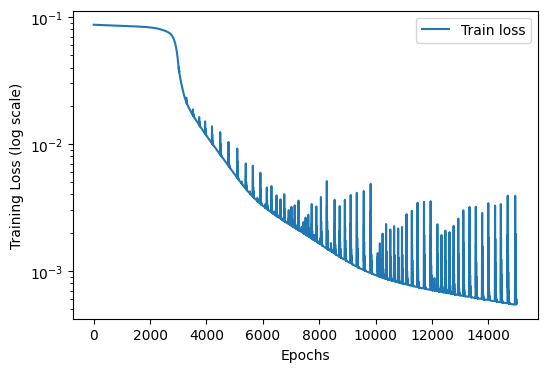

In [ ]:
loss = new_solver.metrics_history['train_loss']

fig = plt.figure(figsize=(6,4))
plt.plot(loss, label = 'Train loss')
plt.xlabel('Epochs')
plt.ylabel('Training Loss (log scale)')
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:

num_solutions = []


a_values = np.linspace(a_min,a_max, 5)
x0_values = np.linspace(x0_min, x0_max,5)

print(a_values)

for k_val in a_values:
    
    def VdP_num_equation(t, state, a=k_val):
        x, y = state
        dxdt = y
        dydt = a * (1-x**2)*y - x
        return [dxdt, dydt]
    
    for x0 in x0_values:

        # Initial conditions
        x0 = x0
        y0 = 0.0
        t_span = (t_min, t_max)
        t_eval = np.linspace(*t_span, 1000)

        # Solve
        num_sol = solve_ivp(VdP_num_equation, t_span, [x0, y0], t_eval=t_eval)

        num_solutions.append(num_sol)

print(len(num_solutions))

In [ ]:
step=1
save_fig=True
best=True

t = torch.linspace(t_min, t_max, 250)

x_solutions = []
y_solutions = []


sol = new_solver.get_solution(best = best)

for i, k_val in enumerate(a_values):

    k_input = k_val*torch.ones_like(t)

    for j, x0_val in enumerate(x0_values):

        x0_input = x0_val * torch.ones_like(t)
        x_sol, y_sol = sol(t, k_input, x0_input)

        x_solutions.append(x_sol.cpu().detach().numpy())
        y_solutions.append(y_sol.cpu().detach().numpy())


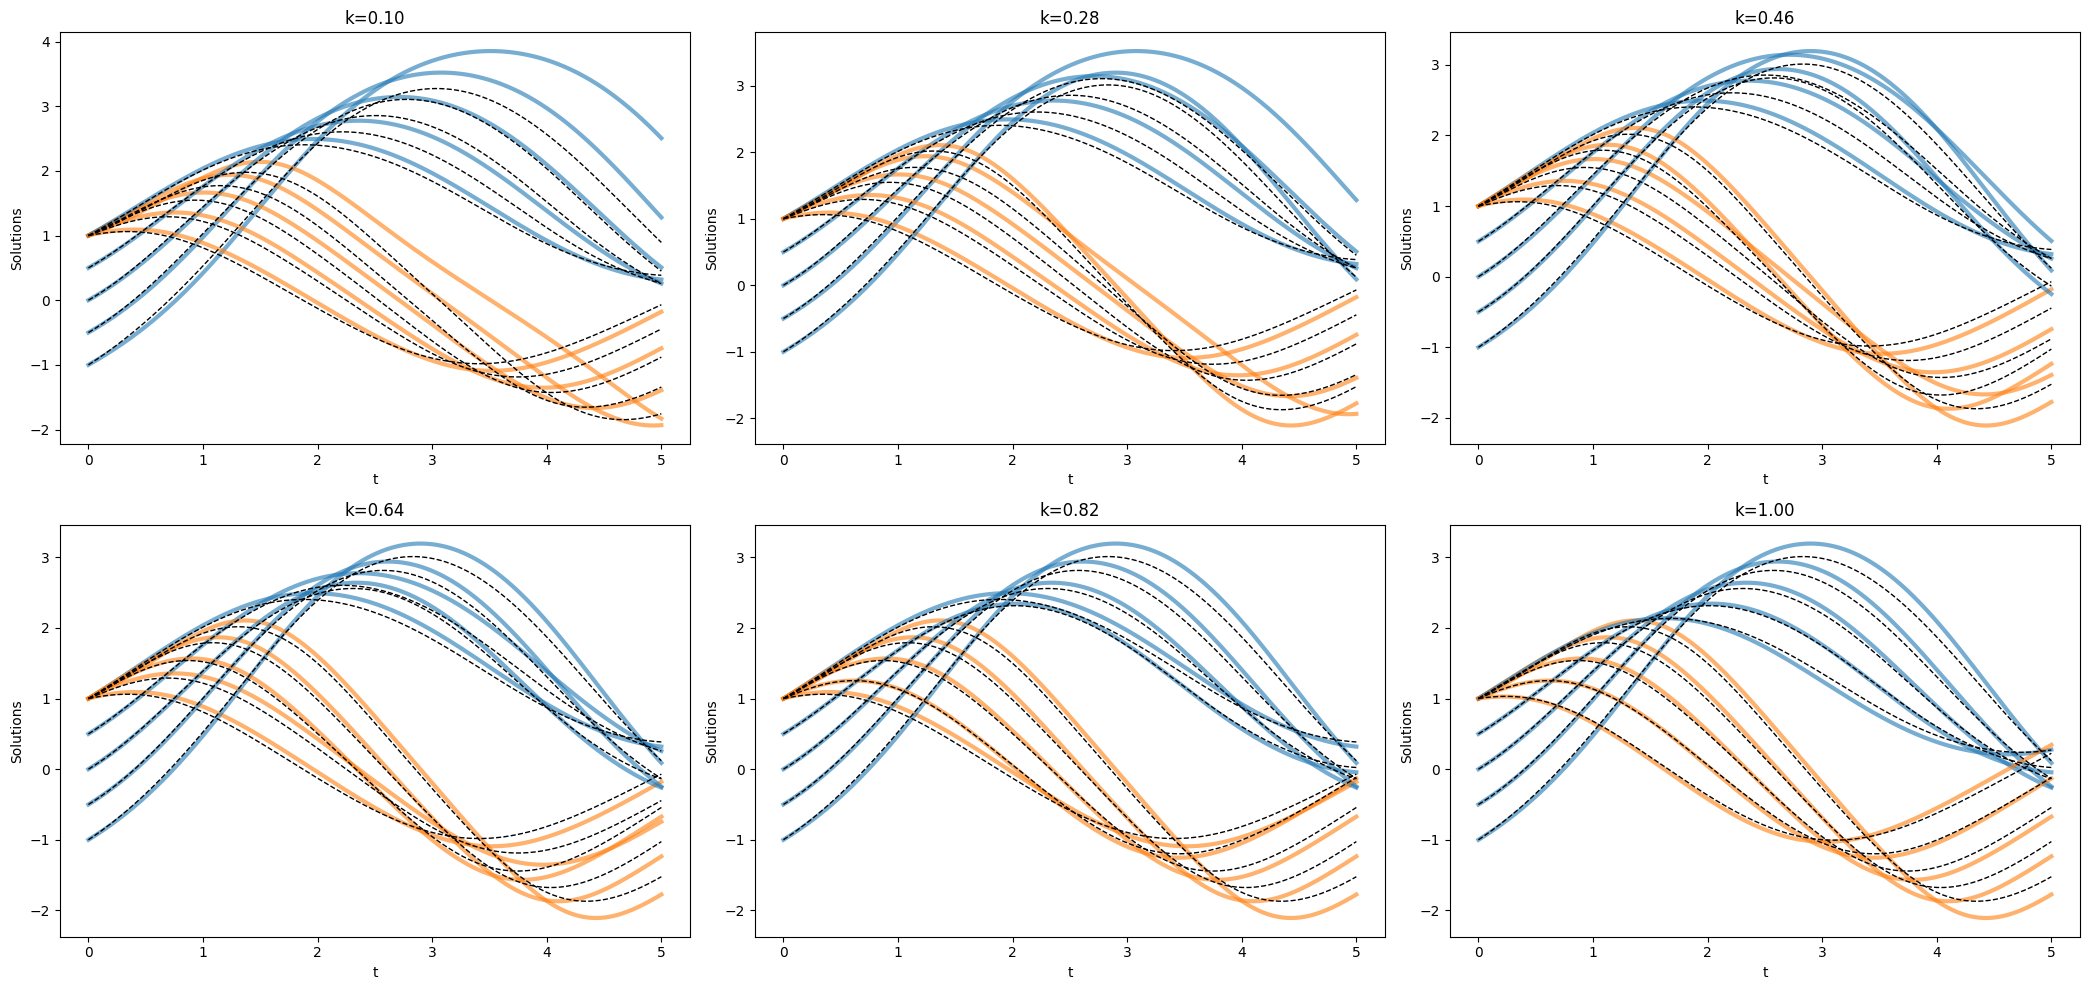

In [ ]:
n_cols = 3
n_rows = math.ceil(len(a_values) / n_cols)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(7*n_cols, 5*n_rows))
ax = ax.flatten()  # make it easier to index in a single loop

for i, k_val in enumerate(a_values):
    for j, x0_val in enumerate(x0_values):
        ax[i].plot(t.cpu().detach().numpy(), x_solutions[i+j], label=f'a={k_val:.2f}, x(t)', linestyle='dashed', linewidth=1, color='k')
        ax[i].plot(t.cpu().detach().numpy(),y_solutions[i+j],label=f'a={k_val:.2f}, y(t)',linestyle='dashed',linewidth=1,color='k'
        )

        ax[i].plot(num_solutions[i+j].t, num_solutions[i+j].y[0], '-', label=f'a={k_val:.2f}, Num x(t)', color='C0', linewidth=3, alpha=0.6, zorder=0)
        ax[i].plot(num_solutions[i+j].t, num_solutions[i+j].y[1], '-', label=f'a={k_val:.2f}, Num y(t)', color='C1', linewidth=3, alpha=0.6, zorder=0)

    ax[i].set_xlabel('t')
    ax[i].set_ylabel('Solutions')
    ax[i].set_title(f'k={k_val:.2f}')
    # ax[i].legend(loc='best')

# hide any empty subplots (if len(k_values) not a multiple of 3)
for k in range(len(k_values), n_rows * n_cols):
    fig.delaxes(ax[k])

fig.tight_layout()
plt.show()

### Plot the residuals

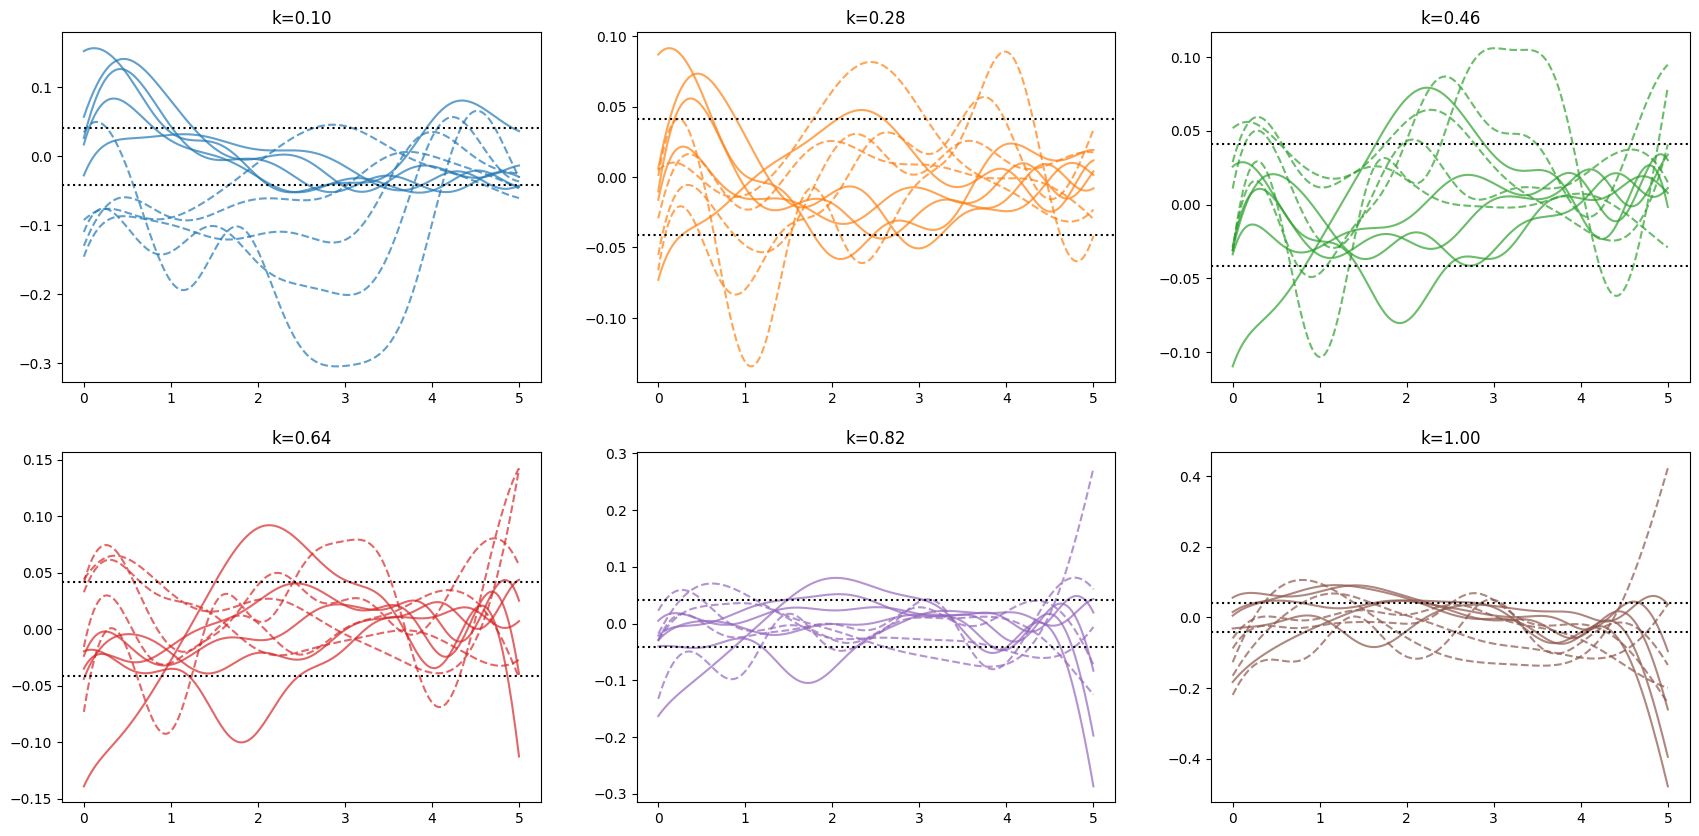

In [ ]:
n_cols = 3
n_rows = math.ceil(len(a_values) / n_cols)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(7*n_cols, 5*n_rows))
ax = ax.flatten()  # make it easier to index in a single loop

for i, k_val in enumerate(a_values):

    k_input = k_val*torch.ones_like(t)

    for j, x0_val in enumerate(x0_values):

        x0_input = x0_val * torch.ones_like(t)

        res1, res2 = new_solver.get_residuals(t, k_input, x0_input, best = False)

        ax[i].plot(t.cpu().detach().numpy(), res1.cpu().detach().numpy(), '-', color = f'C{i}', alpha = 0.7)
        ax[i].plot(t.cpu().detach().numpy(), res2.cpu().detach().numpy(),'--', color = f'C{i}', alpha = 0.7)

    ax[i].axhline(np.sqrt(new_solver.metrics_history['train_loss'][-1]), color='k', linestyle='dotted')
    ax[i].axhline(-np.sqrt(new_solver.metrics_history['train_loss'][-1]), color='k', linestyle='dotted')

    ax[i].set_title(f'k={k_val:.2f}')

plt.show()
